In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from cv2 import aruco
import os
import PIL
import pandas as pd
from scipy import ndimage
from PIL import Image
import imutils

from skimage import color,measure,morphology,feature,filters


In [3]:
cv2.__version__

'4.5.5'

In [39]:
class CakeDetector :
    resolutionData = [1920, 1080]
    size_of_marker = 0.1 # size of arucoTag of table in meter
    offset_x = 100 # offset of reconstruct frame in x
    offset_y = 100 # offset of reconstruct frame in x
    table_size_x = 3000 + offset_x
    table_size_y = 2000 + offset_y
    f = 1
    
    warpMatrix = []
    pink = []
    yellow = []
    brown = []
    y_pos = []
    p_pos = []
    b_pos = []
    posCenter = []
    posGround = []
    cakeLayer = []
    frame_x = table_size_x * f
    frame_y = table_size_y * f

    frame = []

    parameters =  aruco.DetectorParameters_create()
    parameters.adaptiveThreshWinSizeMin = 10
    parameters.adaptiveThreshWinSizeMax = 21
    parameters.adaptiveThreshWinSizeStep=1

    def __init__(self):
        pass

    def initPerspective(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # ------ Detect 4 tag of table to perspective correction ------------------------------------------------
        aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
        corners, ids, rejectedImgPoints = aruco.detectMarkers(frame, aruco_dict,
                                                            parameters=self.parameters)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
        for corner in corners:
            cv2.cornerSubPix(gray, corner, winSize = (3,3), zeroZone = (-1,-1), criteria = criteria)

        frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
        '''
        plt.figure(figsize=(20,20))
        plt.imshow(frame_markers)
        plt.show()'''
        imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
        ar = np.array(corners)
        # Corner extern of reference arucoTag 
        a0 = ar[ids==20,0,0]
        a1 = ar[ids==20,0,1]
        b0 = ar[ids==21,1,0]
        b1 = ar[ids==21,1,1]
        c0 = ar[ids==22,3,0]
        c1 = ar[ids==22,3,1]
        d0 = ar[ids==23,2,0]
        d1 = ar[ids==23,2,1]

        pts1 = np.float32([[a0, a1], [b0, b1], [c0, c1], [d0, d1]])
        pts2 = np.float32([[(1480+50)*self.f, (2475+self.offset_x)*self.f], [(520+50)*self.f, (2475+self.offset_x)*self.f], 
                            [(1480+50)*self.f, (525+self.offset_x)*self.f], [(520+50)*self.f, (525+self.offset_x)*self.f]])

        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        self.warpMatrix = matrix
        result = cv2.warpPerspective(frame, matrix, (int((2000 + self.offset_y)*self.f), int((3000+self.offset_x)*self.f)))
        # -------------------------------------------------------------------------------------------------------
        frame = result

        (w,h,p) = frame.shape
        #split image 3x2 
        splitx = 3
        splity = 2
        marge = 100

        offsetx = int(w/splitx)
        offsety = int(h/splity)

        aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_1000)
        #parameters =  aruco.DetectorParameters_create()


        pos = []
        for i in range(splitx):
            for j in range(splity):
                cutframe = frame[i*offsetx:min((i+1)*offsetx + marge,w),j*offsety:min((j+1)*offsety + marge,h), :]
                try:
                    corners, ids, rejectedImgPoints = aruco.detectMarkers(cutframe, aruco_dict, parameters=self.parameters)
                    frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
                    for k in range(len(ids)):
                        c = corners[k][0]
                        pos.append([ids[k,0],c[:, 0].mean()+j*offsety,c[:, 1].mean()+i*offsetx])
                        #pos.append([ids[k,0],c[1, 0]+j*offsety,c[1, 1]+i*offsetx])     
                except:
                    print("error")
                    pass
        pos = np.asarray(pos)
        y = pos[:,1]
        x = pos[:,2]

        
        # Center coordinates
        center_coordinates = (120, 50)
        
        # Radius of circle
        radius = 50
        
        # Blue color in BGR
        color = (255, 0, 0)
        
        # Line thickness of 2 px
        thickness = 2
        
        # Using cv2.circle() method
        # Draw a circle with blue line borders of thickness of 2 px

        #plt.figure(figsize=(20,20))
        #plt.imshow(frame)
        #plt.plot(y,x,'o')
        #plt.show()
        
        return frame


    def detectAruco(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.warpPerspective(frame, self.warpMatrix, (int((2000 + self.offset_y)*self.f), int((3000+self.offset_x)*self.f)))
        (w,h,p) = frame.shape
        #split image 3x2 
        splitx = 3
        splity = 2
        marge = 100

        offsetx = int(w/splitx)
        offsety = int(h/splity)

        aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_1000)
        #parameters =  aruco.DetectorParameters_create()


        pos = []
        pos_corners = []
        for i in range(splitx):
            for j in range(splity):
                cutframe = frame[i*offsetx:min((i+1)*offsetx + marge,w),j*offsety:min((j+1)*offsety + marge,h), :]
                try:
                    corners, ids, rejectedImgPoints = aruco.detectMarkers(cutframe, aruco_dict, parameters=self.parameters)
                    frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
                    for k in range(len(ids)):
                        c = corners[k][0]
                        pos.append([ids[k,0],c[:, 0].mean()+j*offsety,c[:, 1].mean()+i*offsetx])
                        pos_corners.append([ids[k,0],c[:, 0]+j*offsety,c[:, 1]+i*offsetx])
                        #pos.append([ids[k,0],c[1, 0]+j*offsety,c[1, 1]+i*offsetx])     
                except:
                    print("error")
                    pass
                
        pos = np.asarray(pos)


        l = 15
        s = 18
        h = np.sqrt(s*s+l*l)
        a = np.arctan(l/s)

        pos_center = []
        for i in range(len(pos[:,0])):
            if(pos[i,0] == 36 or pos[i,0] == 13 or pos[i,0] == 47):
                b = np.arctan((pos_corners[i][2][1]-pos_corners[i][2][0])/(pos_corners[i][1][1]-pos_corners[i][1][0]))
                t = np.pi - a - b
                dx = np.cos(t)*h
                dy = np.sin(t)*h
                if(pos_corners[i][2][0]>pos_corners[i][2][3]):
                    pos_center.append([pos[i,0],pos_corners[i][2][0]-dx,pos_corners[i][1][0]-dy])
                else:
                    pos_center.append([pos[i,0],pos_corners[i][2][0]+dx,pos_corners[i][1][0]+dy])

        pos_center = np.asarray(pos_center)

        '''
        plt.figure(figsize=(20,20))
        plt.imshow(frame)
        TagId = [13, 36, 47]
        colorPlot = ['oy', 'ob', 'or']
        for i in range(0,3):
            y = pos[pos[:,0]==TagId[i],1]
            x = pos[pos[:,0]==TagId[i],2]
            plt.plot(y,x,colorPlot[i])

        plt.plot(pos_center[:,2],pos_center[:,1],'o')
        plt.plot(pos_center[:,2],pos_center[:,1]+55,'x')    
        plt.show()'''

        self.frame = frame
        self.posCenter = pos_center
        return pos_center

        pass

    def determinNumberOfLayer(self):
        wide = 100
        height = 100
        plt.figure(figsize=(10,10))
        #plt.imshow(self.frame)
        for k in range(self.posCenter.shape[0]):
            frameLayer = self.frame[round(self.posCenter[k,1]+55):round(self.posCenter[k,1]+55+height),
                                  round(self.posCenter[k,2]-wide/2):round(self.posCenter[k,2]+wide/2),
                                  :]
            
            #frame
            plt.imshow(frameLayer)
            plt.show()

        pass


    def determinNumberOfLayer2(self):
        color_map = ['Y', 'P', 'B']
        self.posGround = self.posCenter.copy()
        np.asanyarray(self.posGround)
        squareBB = 180
        bb_h = 100
        bb_w = 10
        offset_h = 60
        frame = self.frame.copy()
        frame = cv2.GaussianBlur(frame,(7,7),0)
        cakeColor = []
        j = -1
        pos = self.posCenter
        #print(len(pos))
        for k in range(len(pos)):
            #if(pos[k,0] == 36 or pos[k,0] == 13 or pos[k,0] == 47):
            #if(pos[k,0] == 36):
            #j += 1
            '''
            if(pos[k,0] == 13):
                cakeColor.append(['Y','x','x'])
            elif(pos[k,0] == 36):
                cakeColor.append(['B','x','x'])
            elif(pos[k,0] == 47):
                cakeColor.append(['P','x','x'])
            else:
                cakeColor.append(['x','x','x'])
            '''
            markerBox = frame[max(int(pos[k,1]+offset_h),0):int(pos[k,1]+bb_h+offset_h), max(int(pos[k,2]-bb_w/2),0):int(pos[k,2]+bb_w/2),:]
            markerBox = frame[max(int(pos[k,1]-squareBB),0):int(pos[k,1]+squareBB), max(int(pos[k,2]-squareBB),0):int(pos[k,2]+squareBB),:]
            pix_x, pix_y = self.cvtPosPixel(0,0.85)
            angle_rad = np.arctan2((3100-self.posCenter[k,1]),(pix_y)-self.posCenter[k,2])
            angle_deg = angle_rad*180/3.14
            markerBox = imutils.rotate(markerBox, angle=-90+angle_deg)
            markerBox = markerBox[squareBB+offset_h:,squareBB-bb_w:squareBB+bb_w,:]
            #markerBox = frame[max(int(pos[k,1]+offset_h),0):int(pos[k,1]+bb_h+offset_h), max(int(pos[k,2]-bb_w/2),0):int(pos[k,2]+bb_w/2),:]

            markerBox_HSV = cv2.cvtColor(markerBox, cv2.COLOR_RGB2HSV)

            BB_yellow = cv2.inRange(markerBox_HSV,(15, 100, 20), (30, 255, 255) )
            BB_pink = cv2.inRange(markerBox_HSV,(130, 100, 20), (180, 255, 255) )
            #BB_brown = cv2.inRange(markerBox_HSV,(0, 20, 5), (20, 255, 100) )            
            #BB_brown = cv2.inRange(markerBox_HSV,(100, 10, 40), (180, 120, 160) )       
            BB_brown = cv2.inRange(markerBox,(30, 30, 30), (80, 80, 80) )

            BB = [BB_yellow, BB_pink, BB_brown]


            cakeSort = []
            cakeLayer = []
            height = 0
            for i, c in enumerate(BB):
                #input_mask = BB[c]
                input_mask = c
                #labels_mask = measure.label(input_mask[-int(bb_h*2/3):,:]) 
                labels_mask = measure.label(input_mask)                       
                regions = measure.regionprops(labels_mask)
                regions.sort(key=lambda x: x.area, reverse=True)
                if len(regions) > 1:
                    for rg in regions[1:]:
                        labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
                labels_mask[labels_mask!=0] = 1
                BB[i] = labels_mask
                
                region = measure.regionprops(labels_mask)
                if region:
                    minr, minc, maxr, maxc = region[0].bbox
                    width = maxc - minc
                    if(width >=10):                        
                        heightLayer = maxr - minr
                        height += heightLayer
                        cakeSort.append([color_map[i],region[0].centroid[0]])
            cakeSort.sort(key=lambda a: a[1])

            try:
                non = list(zip(*cakeSort))[0]
            except:
                non = []
            cakeColor.append(non)

            if k == 2:
                #plt.imsave('result/brown2.png', markerBox)
                pass
            
            
            self.cakeLayer = cakeColor.copy()
            dy = np.cos(angle_rad)*height
            dx = np.sin(angle_rad)*height
            self.posGround[k,1] = self.posCenter[k,1]+dx
            self.posGround[k,2] = self.posCenter[k,2]+dy
            '''
            print(k)
            print(self.posCenter[0,1])
            print(self.posGround[0,1])
            print('y: ', self.posCenter[k,1],' ¦  x: ', self.posCenter[k,2])

            print(angle_deg)
            print(cakeColor[j])
            
            print("height : ", height)
            plt.figure(figsize=(15,5))
            plt.title("Y / P / B")
            plt.subplot(1,4,1)
            plt.imshow(markerBox)
            plt.subplot(1,4,2)
            plt.imshow(BB[0], cmap='gray')
            plt.subplot(1,4,3)
            plt.imshow(BB[1], cmap='gray')
            plt.subplot(1,4,4)
            plt.imshow(BB[2], cmap='gray')
            plt.show()'''

        #self.plotFrame()
        #print(cakeColor)

    def plotFrame(self):
        plt.figure(figsize=(20,20))
        plt.imshow(self.frame)
        TagId = [13, 36, 47]
        colorPlot = ['oy', 'ob', 'or']
        for i in range(0,3):
            x = self.posCenter[self.posCenter[:,0]==TagId[i],1]
            y = self.posCenter[self.posCenter[:,0]==TagId[i],2]
            plt.plot(y,x,colorPlot[i])
        plt.plot(self.posGround[:,2],self.posGround[:,1],'x')  
        plt.plot(self.posCenter[:,2],self.posCenter[:,1]+55,'x')    
        plt.show()
    def cvtPixelPos(self, x_pix,y_pix):

        x_pos  = (self.frame_x-x_pix)*3.1/self.frame_x
        y_pos  = (self.frame_y-y_pix-self.offset_y/2)*2.1/self.frame_y
        return [x_pos,y_pos]
    
    def cvtPosPixel(self, x_pos,y_pos):

        x_pix  = round((3.1-x_pos)*self.frame_x/3.1)
        y_pix  = round((2.1-y_pos)*self.frame_y/2.1)

        y_pix = -(y_pos*self.frame_y/2.1+self.offset_y/2-self.frame_y)

        return [x_pix ,y_pix]
    
    def formatData(self):
        self.posGround
        pass


In [40]:
cd = CakeDetector()
path_initFrame = 'photo/pistouk_portrait.png'
path_initFrame = 'CakeDetector/calibCouche2.png'
path_initFrame = 'CakeDetector/zoom1.png'
path_Frame = 'CakeDetector/real1.png'

path_initFrame = 'CakeDetector/deux3.png'
path_Frame = 'CakeDetector/deux3.png'
path_initFrame = 'CakeDetector/calibPose1_1.png'
path_Frame = 'CakeDetector/calibPose1_1.png'
frameInit = cv2.imread(path_initFrame)
frame = cv2.imread(path_Frame)

cd.initPerspective(frameInit)


cd.detectAruco(frame)
cd.determinNumberOfLayer2()



In [37]:
cd.posGround[:,1:]

array([[1105.72356458,  499.83410996],
       [ 896.77776156,  284.66999841],
       [ 720.76633816,  294.14442427],
       [ 875.06418792, 1823.45558683],
       [ 676.47690291, 1826.8673998 ],
       [2126.80670625,  521.49626058],
       [2104.75055492, 1601.57694759],
       [1116.15227752, 1603.14752888],
       [3009.73484633,  744.52153416],
       [2529.27102506,  273.90368805],
       [2324.9639298 ,  276.18780805],
       [2126.80670625,  521.49626058],
       [2328.65804081, 1826.8960002 ],
       [2104.75055492, 1601.57694759]])

In [38]:
cd.cakeLayer

[('P',),
 ('B', 'P'),
 ('B', 'P'),
 ('B',),
 ('B',),
 ('B', 'Y'),
 ('P',),
 ('P',),
 ('Y',),
 ('B',),
 ('B',),
 ('B', 'Y'),
 ('B',),
 ('P',)]

In [116]:
n = 6
print(cd.posGround[n,:])
x = cd.posCenter[n,1]
y = cd.posCenter[n,2]

print(cd.cvtPixelPos(x,y))
x = cd.posGround[n,1]
y = cd.posGround[n,2]
print(cd.cvtPixelPos(x,y))

[  13.         2102.26980997  501.48346244]
[1.0272210754152067, 1.5691632728741203]
[0.9977301900294387, 1.548516537559221]


array([[1105.72356458,  499.83410996],
       [ 896.77776156,  284.66999841],
       [ 720.76633816,  294.14442427],
       [ 875.06418792, 1823.45558683],
       [ 676.47690291, 1826.8673998 ],
       [2126.80670625,  521.49626058],
       [2104.75055492, 1601.57694759],
       [1116.15227752, 1603.14752888],
       [3009.73484633,  744.52153416],
       [2529.27102506,  273.90368805],
       [2324.9639298 ,  276.18780805],
       [2126.80670625,  521.49626058],
       [2328.65804081, 1826.8960002 ],
       [2104.75055492, 1601.57694759]])

In [91]:
print(cd.cvtPixelPos(3100,0))

[0.0, 2.05]


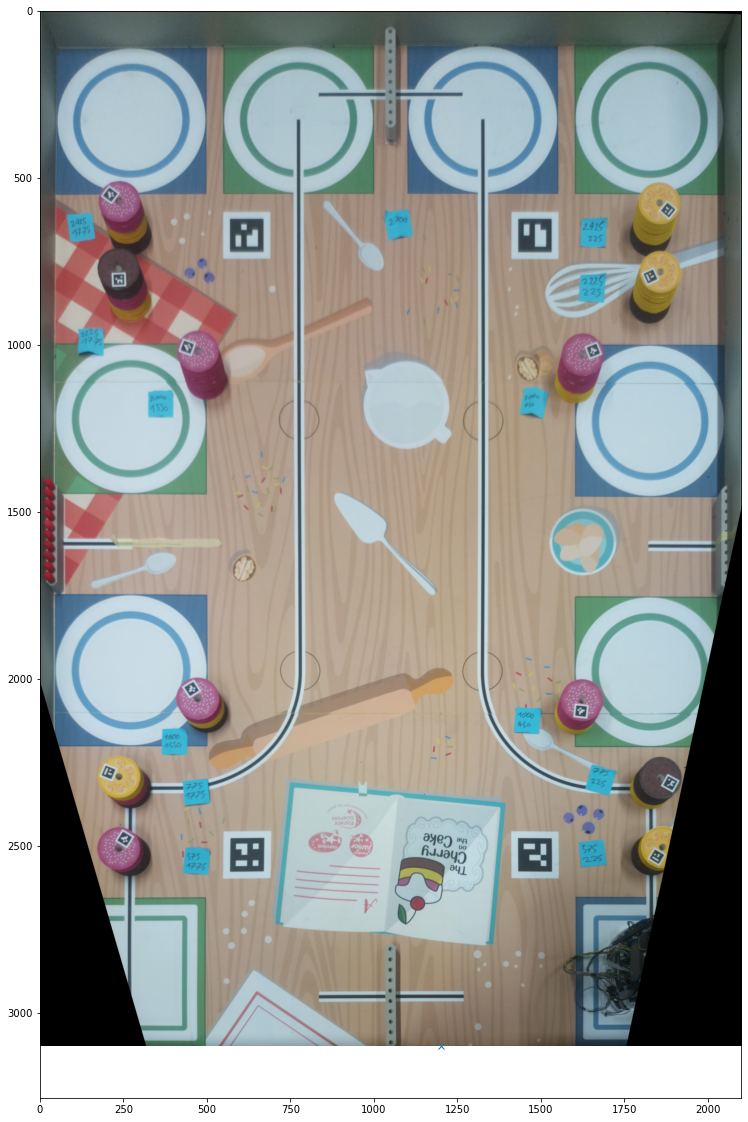

3100 1200.0
0.0 0.85


In [104]:
x,y = cd.cvtPosPixel(0,0.85)
x1,y1 = cd.cvtPixelPos(x,y)
plt.figure(figsize=(20,20))
plt.imshow(cd.frame)
plt.plot(y,x,'x')
plt.show()
print(x,y)
print(x1,y1)

H
50
84
S
38
68
V
32
70


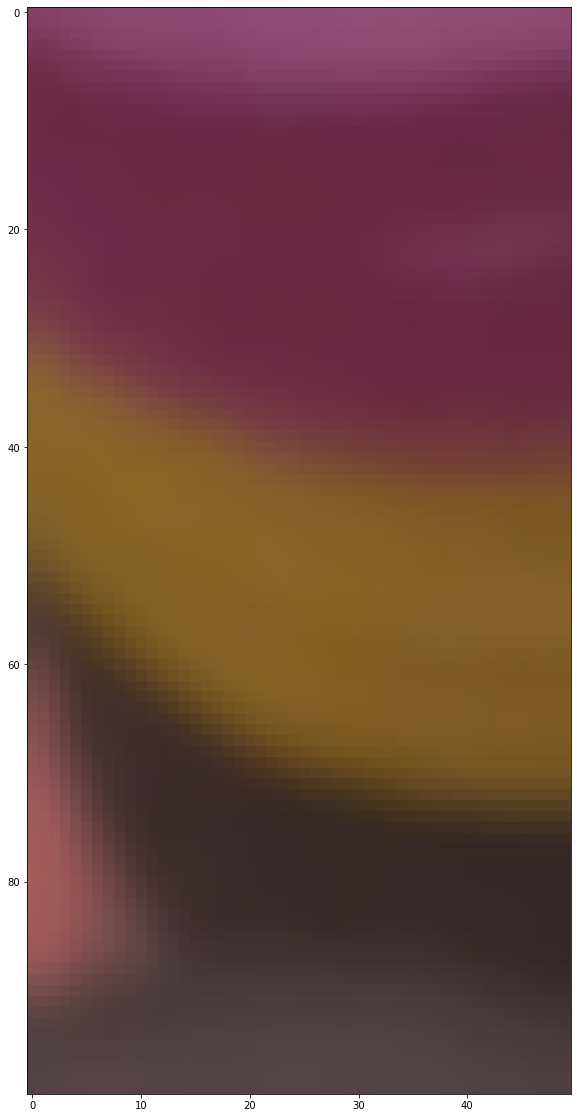

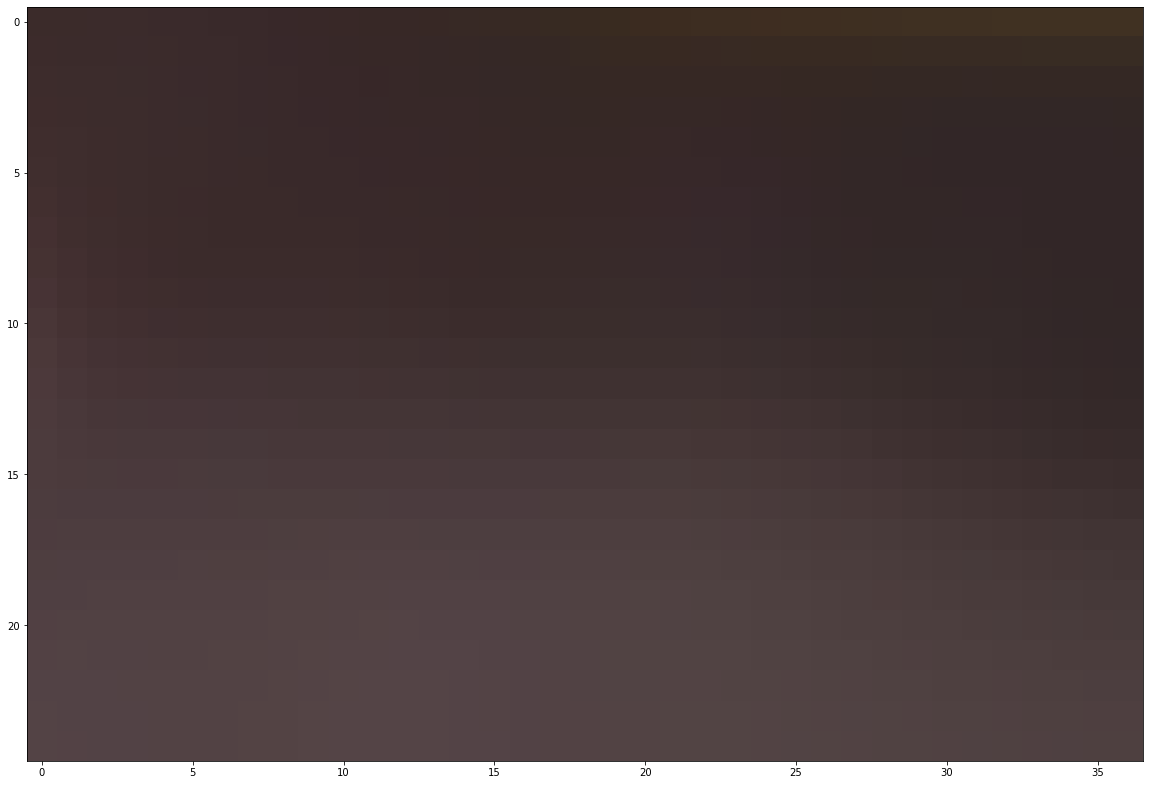

In [131]:
bro1 = cv2.imread('result/brown2.png')
bro1 = cv2.cvtColor(bro1, cv2.COLOR_BGR2RGB)
bro1 = cv2.GaussianBlur(bro1,(7,7),0)
bro = bro1[75:,13:,:]

bro_HSV = cv2.cvtColor(bro, cv2.COLOR_BGR2HSV)
bro_HSV = bro
bro_hsv_array = np.asanyarray(bro_HSV)
print('H')
print(np.min(bro_hsv_array[:,:,0]))
print(np.max(bro_hsv_array[:,:,0]))
print('S')
print(np.min(bro_hsv_array[:,:,1]))
print(np.max(bro_hsv_array[:,:,1]))
print('V')
print(np.min(bro_hsv_array[:,:,2]))
print(np.max(bro_hsv_array[:,:,2]))

plt.figure(figsize=(20,20))
plt.imshow(bro1)
plt.show()
plt.figure(figsize=(20,20))
plt.imshow(bro)
plt.show()


#            BB_brown = cv2.inRange(markerBox_HSV,(100, 10, 40), (180, 120, 160) )

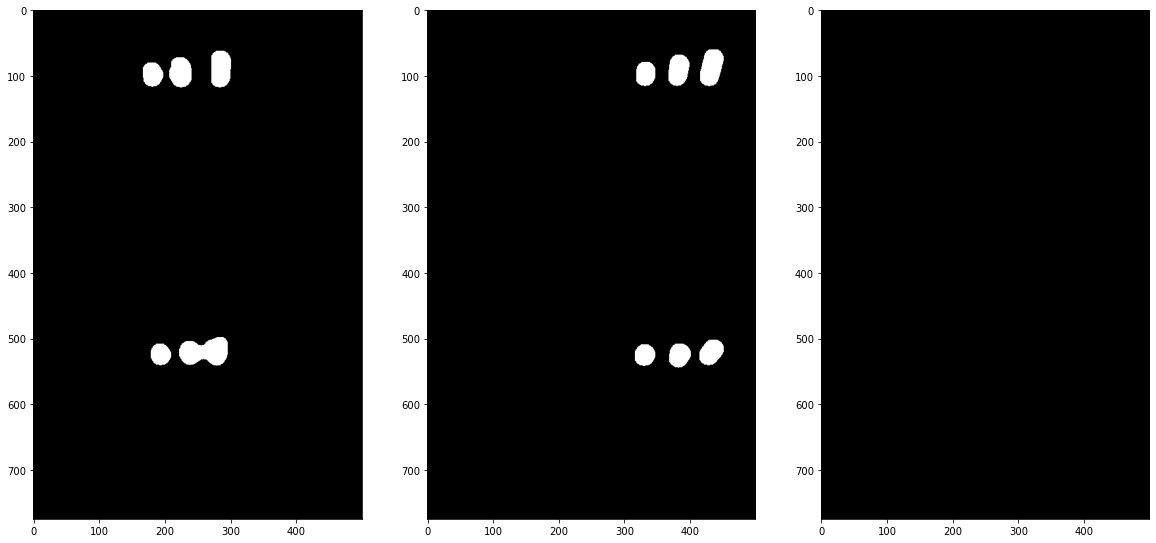

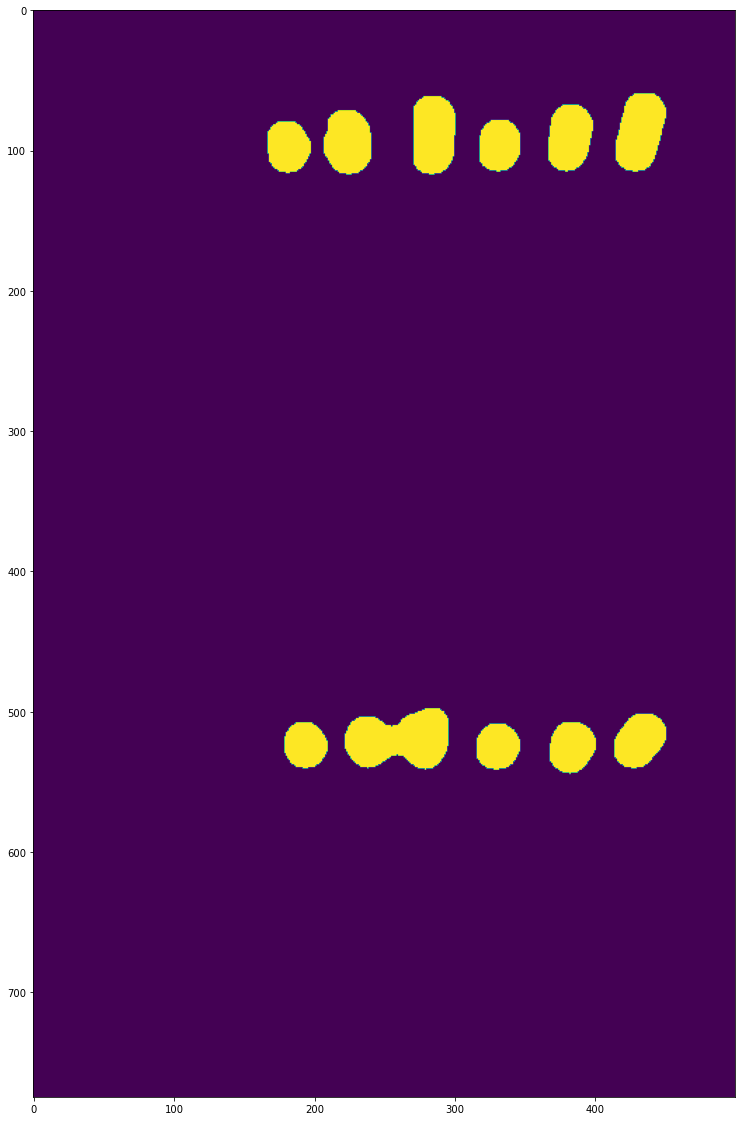

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [147]:
cd.tresh(frame)
[y,p,b] = cd.labeltruc()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

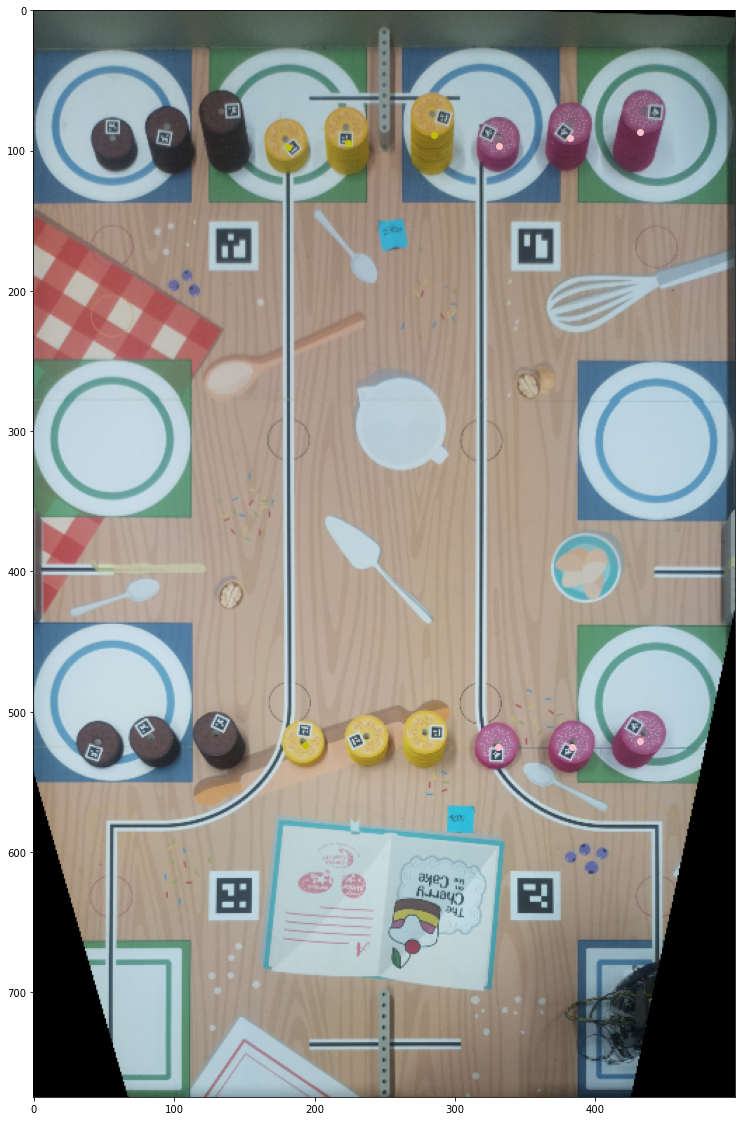

In [148]:
cd.plotfinal()

In [131]:
print(y)
print('\n')
print(p)
print('\n')
print(b)
print('\n')

[[2.809 0.381]
 [2.74  0.641]
 [2.644 0.05 ]
 [2.337 0.838]
 [2.023 0.608]
 [1.23  0.581]
 [0.176 0.8  ]]


[[2.656 1.187]
 [2.504 0.539]
 [2.505 0.151]
 [2.37  1.083]
 [2.287 0.336]
 [1.964 1.07 ]
 [1.351 1.028]
 [0.293 1.047]]


[[2.744 1.499]
 [2.716 0.828]
 [2.398 1.48 ]
 [2.331 0.337]
 [2.226 1.249]
 [2.016 1.456]
 [1.446 1.519]
 [0.179 1.338]]




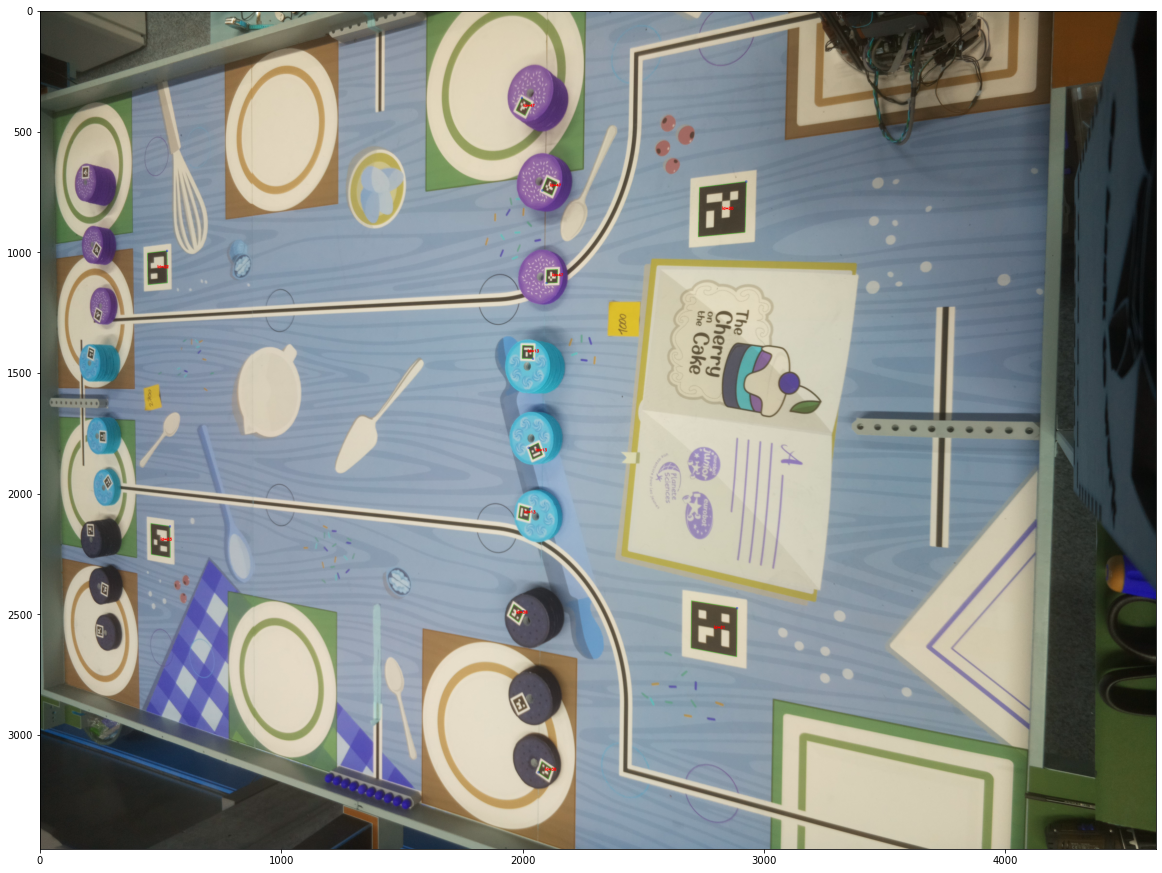

In [48]:
# Charger l'image
img = cv2.imread('CakeDetector/calibCouche2.png')
if img is None:
    print("Erreur : impossible de charger l'image.")
else:
    # Définir le dictionnaire TagAruco à utiliser
    aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)

    # Définir les paramètres de détection TagAruco
    parameters = aruco.DetectorParameters_create()

    # Détecter les marqueurs TagAruco dans l'image
    corners, ids, rejectedImgPoints = aruco.detectMarkers(img, aruco_dict, parameters=parameters)

    if ids is None:
        print("Aucun marqueur TagAruco n'a été détecté dans l'image.")
    else:
        # Afficher les marqueurs détectés dans l'image
        img_with_markers = aruco.drawDetectedMarkers(img, corners, ids)

        # Afficher l'image avec les marqueurs détectés
  
plt.figure(figsize=(20,20))
plt.imshow(img_with_markers)
plt.show()